# Ordered phases in Rydberg systems

In this example notebook, we show how one can prepare ordered phases in Rydberg systems, focusing on the 1D $Z_2$ phase and the 2D checkerboard phase. We will use an adiabatic time-evolution to prepare these many-body ground states.

## Adiabatic evolution

The adiabatic theorem of quantum mechanics states that 

>A physical system remains in its *instantaneous* eigenstate if a given perturbation is acting on it slowly enough and if there is a gap between the eigenvalue and the rest of the Hamiltonian's spectrum. (Born & Fock, 1928)

In other words, a slow-enough change in the parameters of the Hamiltonian will not induce transitions between its ground state and excited states: If the system starts in the ground state of the Hamiltonian at the beginning, it will smoothly transition into the ground state of the Hamiltonian at the end.

The adiabatic theorem plays a key role in preparing the desired many-body ground states in the Rydberg system, the Hamiltonian of which can be expressed as

\begin{align}
H(t) = \sum_{k=1}^N \frac{\Omega(t)}{2}\left(|g_k\rangle\langle r_k| + |r_k\rangle\langle g_k|\right) - \Delta_\text{global}(t){n}_k + \sum_{j=1}^{N-1}\sum_{k=j+1}^N V_{jk}{n}_j{n}_k,
\end{align}

where, for simplicity, we set the phase and the shifting field (See notebook 00 for detailed description of this Hamiltonian) to be zero throughout this notebook. We schedule the driving amplitude $\Omega(t)$ to start from zero ($\Omega(t=0)=0$). Hence, with negative detuning ($\Delta_\text{global}(t=0)<0$), the initial state where all atoms are in the ground state ($\langle n_k\rangle =0$) is the lowest energy eigenstate of the Hamiltonian, the many-body ground state.

To arrive at a target Hamiltonian where the excited states of the atoms are favored, we ramp up the detuning $\Delta_\text{global}$ from large negative to large positive. During the ramp, we apply a large driving amplitude $\Omega$ to open an energy gap between the first excited state and the ground state. According to the adiabatic theorem, if the ramping is slow enough, the system remains in the many-body ground state throughout the evolution. At the end of the AHS program, the Rabi frequency will be turned off and since $\Delta_\text{global}>0$, all the atoms tend to stay in the Rydberg state to lower the energy of the system. However, due to the strong Rydberg interaction, only one atom can be excited to the Rydberg state within its blockade radius.

For a 1D chain of atoms, if we adjust the separation between the atoms such that only neighboring atoms are within the blockade radius, then we will arrive at a state where every second atom is excited, this is called the "$Z_2$ phase". For a 2D square array of atoms, a similar "checkerboard phase" emerges. The common feature of these phases is that the atoms are excited to the Rydberg states in an alternative pattern, complying with the blockade constraint, as shown in the figure below. In the figure, the shaded circles show *half* of the blockade radius such that sites with overlapped circles blockade each other. We show configurations, with black and white sites represent Rydberg and ground state atoms respectively, that comply with the blockade constraint. 

![Blockade_examples.png](Blockade_examples.png)

We will realize these phases in this notebook. To begin, we import the necessary packages.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
tracker = Tracker().start()

In this notebook, we will use `matplotlib` package and `ahs_utils.py` module in the current working directory for visualization purposes and other functionalities.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from braket.ahs.atom_arrangement import AtomArrangement

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from ahs_utils import show_register, show_global_drive, show_final_avg_density, get_drive 

from braket.devices import LocalSimulator

## 1D $Z_2$ phase 

Here we consider a 1D chain of 9 atoms with neighboring atoms separated by $6.1\mu m$. The setup of the system can be generated as follows

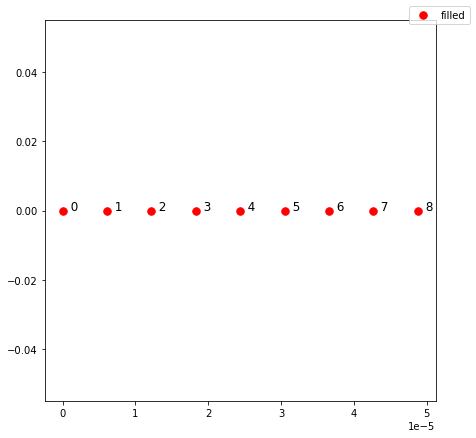

In [3]:
register = AtomArrangement()
separation = 6.1e-6  # in meters 
num_atoms = 9

for k in range(num_atoms):
    register.add([k * separation, 0])
    
show_register(register)

In order to prepare the $Z_2$ ordered state for the atomic chain, we shall design an AHS program that drives the system adiabatically. As described above, we start from $\Omega(t=0)=0$ with $\Delta(t=0)<0$, followed by turning on $\Omega(t)$ and ramping up $\Delta(t)$. We will turn off the driving amplitude at the end of the program. This program can be specified as follows.

In [4]:
time_points = [0, 2.5e-7, 2.75e-6, 3e-6]
amplitude_min = 0
amplitude_max = 1.57e7  # rad / s

detuning_min = -5.5e7  # rad / s
detuning_max = 5.5e7  # rad / s

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

We can plot the waveforms of these driving fields to make sure that they are correctly specified.

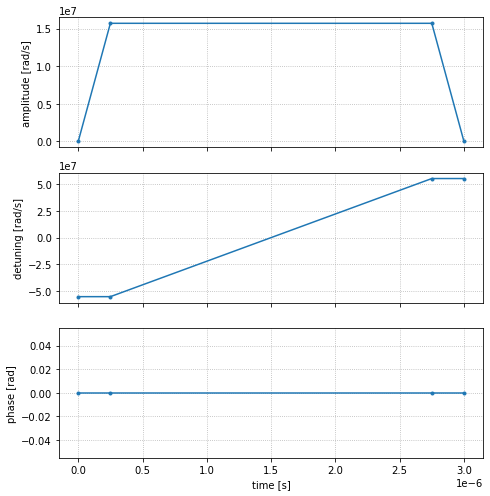

In [5]:
show_global_drive(drive);

Finally, we construct out AHS program from the atomic registers, and the Hamiltonian defined above. 

In [6]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

Before running the program on Quera's Aquila device (See notebook 01), we can first run it on the local simulator to make sure the outcome is the expected $Z_2$ state. Below we have explicitly specified the values of `steps` and `shots`, which are the number of time steps in the simulation and the number of sampling for the final stats, respectively. One could increase the accuracy of the result by increasing the values of these arguments, at the expense of longer runtime. 

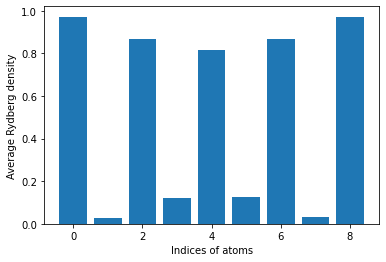

In [7]:
device = LocalSimulator("braket_ahs")
result = device.run(ahs_program, shots=1000, steps=100).result()
show_final_avg_density(result)

We see that the average Rydberg density approximately forms the $Z_2$ pattern. The discrepancy can be attributed to finite size of the system and nonadiabaticity throughout the evolution. We expect that as one increase the system size and the duration of the AHS program, the final Rydberg density will approach the ideal $Z_2$ pattern.

The $Z_2$ phase can be characterized by the density correlation $g_{ij}$ of the $i$-th and the $j$-th atom, which is defined as

\begin{align}
g_{ij} = \langle n_i n_j\rangle - \langle n_i\rangle\langle n_j\rangle,
\end{align}

where $\langle\cdot\rangle$ is the average over the shots.

In [8]:
def get_density_correlation_Z2(result):
    post_sequences = np.array([list(measurement.post_sequence) for measurement in result.measurements])
    return np.cov(post_sequences.T)

gij = get_density_correlation_Z2(result)

The Rydberg density correlation function can be visualized as follows.

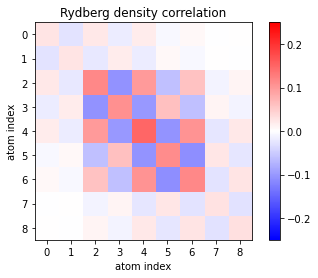

In [9]:
plt.imshow(gij, cmap='bwr', vmin=-0.25, vmax=+0.25)
plt.xticks(range(num_atoms), [f'{i}' for i in range(num_atoms)])
plt.xlabel("atom index")
plt.yticks(range(num_atoms), [f'{j}' for j in range(num_atoms)])
plt.ylabel("atom index")
plt.title('Rydberg density correlation')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

For more explanation and interpretation of the Rydberg density correlation functions, see "Probing many-body dynamics on a 51-atom quantum simulator" by [Bernien et al. (2017)](https://arxiv.org/abs/1707.04344). 

## 2D checkerboard phase 

In two dimension, Rydberg system can exhibit the checkerboard phase, which is analogous to the $Z_2$ phase in 1D. For simplicity, here we create a $3\times 3$ square lattice.

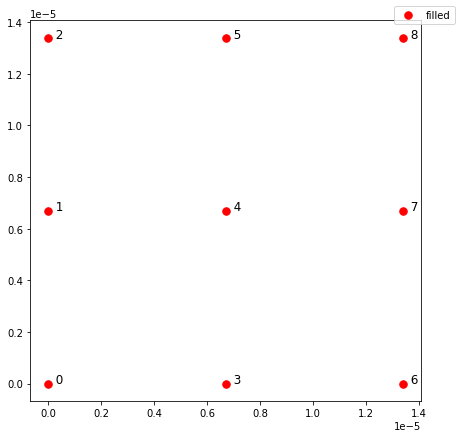

In [10]:
register_2D = AtomArrangement()
separation = 6.7e-6  # in meters 

for k in range(3):
    for l in range(3):
        register_2D.add((k * separation, l * separation))

show_register(register_2D)

We will use the same driving field as the one for generating the $Z_2$ phase. We then assemble the 2D array with the driving field, and run the AHS program on the local simulator. 

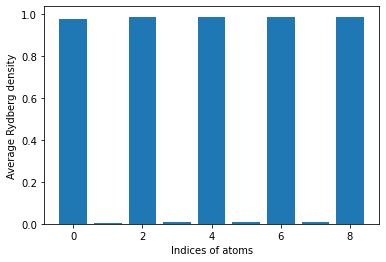

In [11]:
ahs_program_2D = AnalogHamiltonianSimulation(
    register=register_2D, 
    hamiltonian=drive
)

result_2D = device.run(ahs_program_2D, shots=1000, steps=200).result()
show_final_avg_density(result_2D)

We see that the overall pattern mimics the checkerboard pattern, but the central site suffers strong discrepancy. This is due to the finite size of the system and the finite duration of the AHS program, which cause non-adiabatic errors.

For more explanation and interpretation of the 2-d results, see "Quantum Phases of Matter on a 256-Atom Programmable Quantum Simulator" by [Ebadi et al. (2020)](http://arxiv.org/abs/2012.12281). 

## Realizing $Z_2$ and checkerboard phase on a QPU

In previous sections, we have demonstrated two AHS programs for realizing many-body ground states. The results from the local simulator show that the results of the programs meet our expectations. Here we will run the same AHS program on the Aquila device. 

<div class="alert alert-block alert-info">
<b>Note: </b> Some atoms may be missing even if the shot was successful. We recommend comparing <code>pre_sequence</code> of each shot with the requested atom filling in the AHS program specification.  
</div>

In [12]:
from braket.aws import AwsDevice 
device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

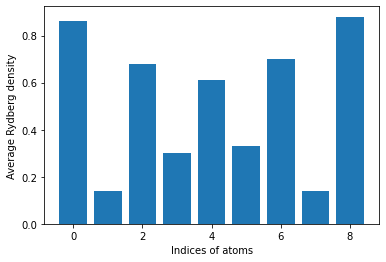

In [13]:
result_1D_aquila = device.run(ahs_program, shots=100).result()
show_final_avg_density(result_1D_aquila)

We can calculate the density correlation function for the result obtained from Aquila

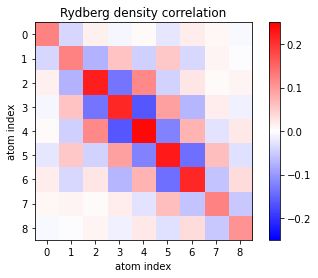

In [14]:
gij_aquila = get_density_correlation_Z2(result_1D_aquila)

plt.imshow(gij_aquila, cmap='bwr', vmin=-0.25, vmax=+0.25)
plt.xticks(range(num_atoms), [f'{i}' for i in range(num_atoms)])
plt.xlabel("atom index")
plt.yticks(range(num_atoms), [f'{j}' for j in range(num_atoms)])
plt.ylabel("atom index")
plt.title('Rydberg density correlation')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

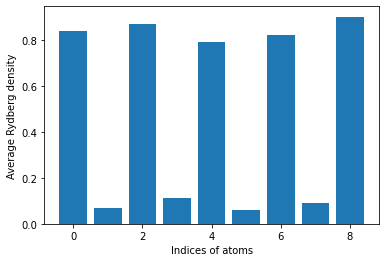

In [15]:
result_2D_aquila = device.run(ahs_program_2D, shots=100).result()
show_final_avg_density(result_2D_aquila)

In summary, in this notebook we have demonstrated how to realize the 1D $Z_2$ phase and 2D checkerboard phase via adiabatic transition on the Rydberg systems. These are interesting many body phases in their own right, and serve as the starting points for the more involved use cases. 

In [16]:
print("Task Summary")
print(tracker.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")

Task Summary
{'arn:aws:braket:us-east-1::device/qpu/quera/Aquila': {'shots': 200, 'tasks': {'COMPLETED': 2}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 2.60 USD
